In [1]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)
!nvidia-smi

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.phy.mimo import StreamManagement

#from sionna.phy.ofdm import CSIGridMapper
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, ResourceGridDemapper, LSChannelEstimator, LMMSEEqualizer
from sionna.phy.ofdm import OFDMModulator, OFDMDemodulator, RemoveNulledSubcarriers, ZFEqualizer

from sionna.phy.channel.tr38901 import Antenna, AntennaArray, CDL, UMi, UMa, RMa
from sionna.phy.channel import gen_single_sector_topology as gen_topology
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel
from sionna.phy.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel

from sionna.phy.fec.ldpc.encoding import LDPC5GEncoder
from sionna.phy.fec.ldpc.decoding import LDPC5GDecoder

from sionna.phy.mapping import Mapper, Demapper, BinarySource, QAMSource

from sionna.phy.utils import ebnodb2no, sim_ber
from sionna.phy.utils.metrics import compute_ber
# from sionna.ofdm import CSIGridMapper


2025-08-04 03:19:59.669434: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 03:20:00.022298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754295600.174532   49715 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754295600.220259   49715 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754295600.520188   49715 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Number of GPUs available : 1
Only GPU number 0 used.
Mon Aug  4 03:20:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              6W /   55W |      12MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N

Tx_Power: 0.17728766960431616
Noise: -120.22878745280337


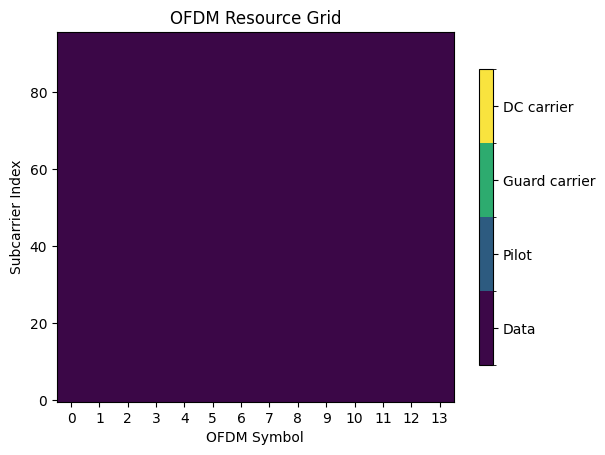

In [5]:
scenario = "umi"
carrier_frequency = 5.3e9
direction = "uplink"
num_ut = 1
batch_size = 5000

num_RB   = 8
num_symbols = 14
num_SC = 96
fft_size = 12*num_RB
subcarrier_spacing = 30e3

## Tx Power
TxPower_dBm     = 20 # in dBm
TxPower         = 10**((TxPower_dBm-30)/10)
TxPower_SC      = TxPower/(num_SC)
TxPower_SC_dBm  = 10*np.log10(TxPower_SC*1000)

# Noise Power
noise_psd       = -174                                  # in dBm/Hz
noise_figure    = 9                                     # in dB
noise_SC_Watt   = 10**((noise_psd + noise_figure - 30)/10)*subcarrier_spacing
noise_SC_dBm    = 10*np.log10(noise_SC_Watt*1000)

print("Tx_Power:",TxPower_SC_dBm)
print("Noise:",noise_SC_dBm)

tf.random.set_seed(1)
# Define the UT antenna array
ut_array = Antenna(polarization="single",
                   polarization_type="V",
                   antenna_pattern="omni",
                   carrier_frequency=carrier_frequency)

# Define the BS antenna array
bs_array = AntennaArray(num_rows=1,
                             num_cols=1, # We want to transmitter to be equiped with the 16 rx antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             polarization_type="V",
                             antenna_pattern="omni",
                             polarization="single",
                             carrier_frequency=7.2e9)

# Create channel model
channel_model = UMi(carrier_frequency=carrier_frequency,
                    o2i_model="low",
                    ut_array=ut_array,
                    bs_array=bs_array,
                    direction=direction,
                    enable_pathloss=True,
                    enable_shadow_fading=True)

# Generate the topology
ut_dist = 10
topology = gen_topology(batch_size, num_ut, scenario,min_bs_ut_dist=ut_dist, min_ut_velocity=0.33, max_ut_velocity=8.33,indoor_probability=0)

# Set the topology
channel_model.set_topology(*topology)
ut_loc = topology[0]
bs_loc = topology[1]
ut_vel = topology[4]

# The number of transmitted streams is equal to the number of UT antennas
num_streams_per_tx = 1

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.zeros([1, num_ut])
rx_tx_association[:, 0] = 1
#rx_tx_association[:, 1] = 1

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly simple. However, it can get complicated
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=fft_size,
                  subcarrier_spacing=subcarrier_spacing,
                  num_tx=num_ut,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=0,
                  pilot_pattern = None,
                  pilot_ofdm_symbol_indices = None)
rg.show();

In [6]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.3 # The code rate
n = int(rg.num_data_symbols*num_bits_per_symbol)  # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()
qam_source = QAMSource(num_bits_per_symbol)

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# CSI-RS mapper
#csi_mapper = CSIGridMapper(rg)

#rg_demap = ResourceGridDemapper(rg, sm)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# CSI-RS estimator will provide the raw channel estimates
#csi_est = CSIrsChannelEstimator(rg, sm)
#csi_est = CSIrsChannelEstimator(rg, sm, TxPower_SC, interpolation_type = 'lin')

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
zf_equ = ZFEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

# OFDM CHannel
ofdm_channel = OFDMChannel(channel_model, rg, add_awgn=True, normalize_channel=False, return_channel=True)
channel_freq = ApplyOFDMChannel(add_awgn=True)
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)



## Classical Communication System

In [10]:
tf.random.set_seed(42)

## Transmitter 
b = binary_source([batch_size, num_ut, rg.num_streams_per_tx, n])
#c = encoder(b)                ## All bits are information bits for now

x = mapper(b)                  # Mapping bits to modulation symbols
x_rg = rg_mapper(x)            # Mapping symbols to OFDM resources
x_rg = np.sqrt(TxPower_SC) * x_rg      # Assigning transmit power

## Passing through wireless channel
a, tau = channel_model(num_time_samples=rg.num_ofdm_symbols, sampling_frequency=1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)

#Receiver (Signal + Channel + Thermal Noise : AWGN)
no = noise_SC_Watt
y = channel_freq(x_rg, h_freq, no)            ## This is your input to Neural Rx: Received Signal, Optional Inputs : H_Freq, No
print("Received Signal Shape : ", y.shape)

# Channel Estimation
returnCompleteRG = True;    num_ant_ports = 1
#h_freq_d_DL_hat, err_var = csi_est([y, no, num_ant_ports, returnCompleteRG])
h_freq_d_DL_hat = h_freq

#x_hat = tf.squeeze(tf.matmul(g, y), axis=-1)
x_hat, no_eff = zf_equ(y, h_freq_d_DL_hat, tf.zeros(h_freq_d_DL_hat.shape), no) 
x_hat = x_hat / np.sqrt(TxPower_SC)

llr = demapper(x_hat, no_eff)       ## This is your ground truth label for Neural Rx

#b_hat = decoder(llr)
b_hat = tf.cast(tf.less(0.0, llr), llr.dtype)


# Compute Mean Squared Error (MSE)
mse = tf.reduce_mean(tf.abs(h_freq_d_DL_hat - h_freq)**2)
print("CSI Est NMSE : ", mse / tf.reduce_mean(tf.abs(h_freq)**2))

print("BER: {}".format(compute_ber(b, b_hat).numpy()))


Received Signal Shape :  (5000, 1, 1, 14, 96)
CSI Est NMSE :  tf.Tensor(0.0, shape=(), dtype=float32)
BER: 0.03477596726190476


## Neural Rx : NVIDIA Model

In [ ]:
from tensorflow.keras.optimizers import Adam, AdamW
# For the implementation of the neural receiver
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

num_conv_channels = 128
n = int(rg.num_data_symbols*num_bits_per_symbol)
class ResidualBlock(Layer):
    def build(self, input_shape):
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels, kernel_size=[3,3], padding='same', activation=None)
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels, kernel_size=[3,3], padding='same', activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z)
        z = z + inputs  # skip connection
        return z


# NeuralReceiver with y and h inputs
class NeuralReceiver(Layer):
    def build(self, input_shape):
        self._input_conv = Conv2D(filters=num_conv_channels, kernel_size=3, padding='same', activation=None)
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        self._output_conv = Conv2D(filters=num_bits_per_symbol, kernel_size=3, padding='same', activation=None)

    def call(self, inputs):
        y, h = inputs  # y: (batch,1,num_symbols,num_SC), h: (batch,1,1,1,1,num_symbols,num_SC)
        batch_size = tf.shape(y)[0]

        # transpose to (batch, num_symbols, num_SC, 1)
        y = tf.transpose(y, [0, 2, 3, 1])  # (batch,num_symbols,num_SC,1)
        h = tf.transpose(h, [0, 2, 3, 1])  # same shape as y

         # === Only keep symbol index 1 ===
        symbol_mask = tf.one_hot(1, depth=tf.shape(h)[1], dtype=h.dtype)  # shape (num_symbols,)
        symbol_mask = tf.reshape(symbol_mask, [1, -1, 1, 1])  # shape (1, num_symbols, 1, 1)
        h = h * symbol_mask  # broadcasting to mask out all symbols except index 1

        # === Add noise to h to achieve NMSE = 0.001 === (Synthetci Channel Estimation Effect)
        # === Add noise to h to achieve NMSE = 0.001 ===
        h_power = tf.reduce_mean(tf.abs(h)**2)
        noise_power = 0.001 * h_power

        # Generate complex Gaussian noise
        noise_real = tf.random.normal(tf.shape(h), mean=0.0, stddev=1.0, dtype=tf.float32)
        noise_imag = tf.random.normal(tf.shape(h), mean=0.0, stddev=1.0, dtype=tf.float32)
        noise = tf.complex(noise_real, noise_imag)  # tf.complex64

        # Normalize noise to unit power and then scale
        noise_norm_factor = tf.sqrt(tf.reduce_mean(tf.abs(noise)**2))  # real-valued
        noise = noise / tf.cast(noise_norm_factor, tf.complex64)       # safe division
        noise = noise * tf.cast(tf.sqrt(noise_power), tf.complex64)

        h = h + noise  # Noisy channel now has NMSE ≈ 0.1
        # Normalize y and h power
        y_power = tf.reduce_mean(tf.abs(y), axis=[1,2,3], keepdims=True) + 1e-6
        h_power = tf.reduce_mean(tf.abs(h), axis=[1,2,3], keepdims=True) + 1e-6
        y_norm = y / tf.cast(y_power, y.dtype)
        h_norm = h / tf.cast(h_power, h.dtype)

        # Separate real and imag parts and concat last dim
        y_ri = tf.concat([tf.math.real(y_norm), tf.math.imag(y_norm)], axis=-1)  # (batch,num_symbols,num_SC,2)
        h_ri = tf.concat([tf.math.real(h_norm), tf.math.imag(h_norm)], axis=-1)  # (batch,num_symbols,num_SC,2)
        #h_ri = tf.zeros((batch_size, num_symbols, num_SC, 2), dtype=tf.float32)

        # Concatenate y and h along last dim => shape (batch,num_symbols,num_SC,4)
        z = tf.concat([y_ri, h_ri], axis=-1)
        print(z.shape)

        # Pass through conv and residual blocks
        z = self._input_conv(z)
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        z = self._output_conv(z)

        # Flatten output to (batch, 1, 1, n)
        z = tf.reshape(z, [batch_size, 1, 1, num_symbols * num_SC * num_bits_per_symbol])
        return z

def binary_sigmoid_cross_entropy(bit_labels: tf.Tensor, pred_llr: tf.Tensor) -> tf.Tensor:
    """
    Binary cross-entropy loss with sigmoid applied to predicted LLRs,
    ignoring invalid bits labeled as -1.

    Args:
        bit_labels: Tensor of shape [batch, symbols, subcarriers, bits], with labels in {0,1} or -1 for invalid bits.
        pred_llr: Tensor of same shape, raw logits (LLRs).

    Returns:
        Scalar tensor: average loss over valid bits only.
    """
    bit_labels = tf.cast(bit_labels, pred_llr.dtype)

    # Find valid bits mask (exclude bits with label -1)
    valid_mask = tf.not_equal(bit_labels, -1)

    # Apply sigmoid to logits to get bit probabilities
    bit_prob = tf.sigmoid(pred_llr)

    # Mask out invalid bits in predictions and labels
    bit_prob_masked = tf.boolean_mask(bit_prob, valid_mask)
    bit_labels_masked = tf.boolean_mask(bit_labels, valid_mask)

    # Compute binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(bit_labels_masked, bit_prob_masked)

    # Average loss over valid bits
    loss = tf.reduce_mean(bce)

    return loss

# Build the model inputs
input_y = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)
input_h = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)


# === Prepare your data ===
# Assuming you have tensors: y (batch,1,1,num_symbols,num_SC), h_freq (batch,1,1,1,1,num_symbols,num_SC), llr (batch,num_symbols,num_SC,num_bits_per_symbol)

# Example for llr_probs preprocessing
llr_probs = tf.sigmoid(llr)
llr_probs = tf.reshape(llr_probs, [llr_probs.shape[0], 1, 1, -1])  # flatten bits, symbols and SC into last dim

# Squeeze and reshape y and h properly
y_data = tf.squeeze(y, axis=(2))              # from (N,1,1,14,96) to (N,1,14,96)
print("Rx Signal Power : ", tf.reduce_mean(tf.abs(y)**2))

h_data = tf.squeeze(h_freq, axis=[1,2,3]) # from (N,1,1,1,1,14,96) to (N,14,96)
print("Channel Power : ", tf.reduce_mean(tf.abs(h_freq)**2))
#h_data = tf.expand_dims(h_data, axis=1)    # (N,1,14,96)

# Instantiate model
receiver = NeuralReceiver()
output_llrs = receiver([input_y, input_h])
receiver_model = Model(inputs=[input_y, input_h], outputs=output_llrs)
# Compile
receiver_model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_sigmoid_cross_entropy)

# Now split train/val
dataset_size = y_data.shape[0]
indices = tf.random.shuffle(tf.range(dataset_size))
train_size = int(0.8 * dataset_size)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

y_train = tf.gather(y_data, train_indices)  # shape (train_size, 1, 14, 96)
y_val = tf.gather(y_data, val_indices)

h_train = tf.gather(h_data, train_indices)  # shape (train_size, 1, 14, 96)
h_val = tf.gather(h_data, val_indices)

llr_train = tf.gather(llr_probs, train_indices)
llr_val = tf.gather(llr_probs, val_indices)

# Train
receiver_model.fit(
    [y_train, h_train],
    llr_train,
    validation_data=([y_val, h_val], llr_val),
    batch_size=32,
    epochs=50
)

## Evaluating the Neural Receiver

In [ ]:
# Predict LLRs
llr_pred = receiver_model.predict([y_val, h_val])  # Usually NumPy array
bits_pred = tf.cast(tf.less(0.0, llr_pred), llr.dtype)

#Give the ground truth b bits corresponding to your validation set here ...
#print("BER: {}".format(compute_ber(b, bits_pred).numpy()))

## NI's Version of DeepRx Model

In [ ]:
class ResNetBlockProperties:
    """Structure that holds all configurational parameters of the ResNet blocks."""

    num_blocks: int = 0
    kernel_size: list = []
    dilation_rate: list = []
    num_filter: list = []

class DeepRx:
    """DeepRx neural network model"""

    def __init__(
        self,
        num_ofdm_sym: int,
        num_subcar: int,
        num_ant: int,
        res_net_config: ResNetBlockProperties,
        num_output_llr: int,
        use_submodels: bool,
    ):
        """Initializes the network topology"""

        # number of symbols in time: S
        self.num_ofdm_sym = num_ofdm_sym
        # number of subcarriers: F
        self.num_subcar = num_subcar
        # number of antennas: N_r
        self.num_ant = num_ant
        # number of output LLRs: B
        self.num_output_llr = num_output_llr

        # RX data input: complex value already split into two channels
        y = tf.keras.layers.Input(shape=(num_ofdm_sym, num_subcar, 2 * num_ant), name="RX-Data-In")
        # TX pilots: complex value already split into two channels
        x_p = tf.keras.layers.Input(shape=(num_ofdm_sym, num_subcar, 2), name="TX-Pilot-In")
        # raw channel estimate: complex value already split into two channels
        h_r = tf.keras.layers.Input(shape=(num_ofdm_sym, num_subcar, 2 * num_ant), name="Raw-Channel-Est-In")
        # concatenate input layers
        concat = tf.keras.layers.concatenate([y, x_p, h_r], name="Concat")
        # convolutional input layer
        x = tf.keras.layers.Conv2D(64, (3, 3), dilation_rate=(1, 1), padding="same", activation=None, name="Conv-In")(
            concat
        )
        # construct ResNet blocks
        for block_idx in range(res_net_config.num_blocks):
            # generate ResNet block as compact sub-models
            if use_submodels:
                _, res_net_block = self.create_res_net_block(
                    input=x,
                    filter_size=tuple(res_net_config.kernel_size[block_idx]),
                    dilation=tuple(res_net_config.dilation_rate[block_idx]),
                    num_filter=res_net_config.num_filter[block_idx],
                    res_net_block_idx=block_idx,
                )
                x = res_net_block(x)
            # generate ResNet block with all sub-layers visible
            else:
                x, _ = self.create_res_net_block(
                    input=x,
                    filter_size=tuple(res_net_config.kernel_size[block_idx]),
                    dilation=tuple(res_net_config.dilation_rate[block_idx]),
                    num_filter=res_net_config.num_filter[block_idx],
                    res_net_block_idx=block_idx,
                )
        # convolutional output layer: LLR
        output = tf.keras.layers.Conv2D(
            self.num_output_llr, (3, 3), dilation_rate=(1, 1), padding="same", activation=None, name="Conv-Out"
        )(x)
        # instantiate complete model
        self.model = tf.keras.Model(inputs=[y, x_p, h_r], outputs=output, name="DeepRx")

    def create_res_net_block(
        self,
        input: tf.Tensor,
        filter_size: tuple,
        dilation: tuple,
        num_filter: int,
        res_net_block_idx: int,
    ):
        """Creates the ResNet sub-blocks"""
        x = tf.keras.layers.BatchNormalization(name=f"BN-{res_net_block_idx}-0")(input)
        x = tf.keras.layers.ReLU(name=f"ReLU-{res_net_block_idx}-0")(x)
        x = tf.keras.layers.SeparableConv2D(
            filters=num_filter,
            kernel_size=filter_size,
            dilation_rate=dilation,
            depth_multiplier=1,
            padding="same",
            name=f"Separable-Conv-{res_net_block_idx}-0",
        )(x)
        x = tf.keras.layers.BatchNormalization(name=f"BN-{res_net_block_idx}-1")(x)
        x = tf.keras.layers.ReLU(name=f"ReLU-{res_net_block_idx}-1")(x)
        x = tf.keras.layers.SeparableConv2D(
            filters=num_filter,
            kernel_size=filter_size,
            dilation_rate=dilation,
            depth_multiplier=1,
            padding="same",
            name=f"Separable-Conv-{res_net_block_idx}-1",
        )(x)

        # When ResNet block's output depth is increased or decreased, also the residual path has to be up- or downsampled.
        # This can be achieved via 1x1 convolutions.
        if input.shape[3] != num_filter:
            x_shortcut = tf.keras.layers.Conv2D(num_filter, (1, 1), name=f"Conv-Depth-Adjust-{res_net_block_idx}")(
                input
            )
            # TODO: do we need additional BN and ReLU activation here?
            x_shortcut = tf.keras.layers.BatchNormalization(name=f"BN-{res_net_block_idx}-2")(x_shortcut)
            # x_shortcut = tf.keras.layers.ReLU(name=f"ReLU-{res_net_block_idx}-2")(x_shortcut)
        else:
            x_shortcut = input

        output = tf.keras.layers.Add(name=f"Add-{res_net_block_idx}")([x_shortcut, x])

        res_net_model = tf.keras.Model(inputs=input, outputs=output, name=f"ResNet-Block-{res_net_block_idx}")

        return output, res_net_model


## Divya's Previous Version for Reference

In [74]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization, BatchNormalization, Dropout
from tensorflow.nn import relu
from tensorflow.keras.regularizers import l2
from sionna.phy.utils import log10, insert_dims

class ResidualBlock(Layer):
    def __init__(self):
        super().__init__()
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=128, kernel_size=[3,3], padding='same', use_bias=False, kernel_regularizer=l2(1e-4))
        self._bn_1 = BatchNormalization()
        self._dropout_1 = Dropout(0.3)  # Dropout rate 20%

        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=128, kernel_size=[3,3], padding='same', use_bias=False, kernel_regularizer=l2(1e-4))
        self._bn_2 = BatchNormalization()
        self._dropout_2 = Dropout(0.3)

    def call(self, inputs, training=False):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._bn_1(z, training=training)
        z = self._dropout_1(z, training=training)

        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z)
        z = self._bn_2(z, training=training)
        z = self._dropout_2(z, training=training)

        return z + inputs

class NeuralReceiver(Layer):
    def __init__(self):
        super().__init__()
        self._input_conv = Conv2D(filters=128, kernel_size=[3,3], padding='same', use_bias=False)
        self._input_bn = BatchNormalization()

        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()

        self._output_conv = Conv2D(filters=num_bits_per_symbol, kernel_size=[3,3], padding='same', activation='sigmoid')

    def call(self, y, no, training=False):
        # y shape: [B, 1, C, T, F]
        no = log10(no)

        y = tf.squeeze(y, axis=1)          # [B, C, T, F]
        y = tf.transpose(y, [0, 2, 3, 1])  # [B, T, F, C]

        no = tf.expand_dims(no, axis=1)    # [B, 1, 1]
        no = tf.expand_dims(no, axis=2)    # [B, 1, 1, 1]
        no = tf.tile(no, [1, tf.shape(y)[1], tf.shape(y)[2], tf.shape(y)[3]])

        real_y = tf.math.real(y)
        imag_y = tf.math.imag(y)
        z = tf.concat([real_y, imag_y], axis=-1)  # [B, T, F, 2*C+1]

        #print("Power before normalization:",tf.reduce_mean(tf.abs(z)**2))
        # Normalize input
        mean = tf.reduce_mean(z, axis=[1, 2, 3], keepdims=True)
        std = tf.math.reduce_std(z, axis=[1, 2, 3], keepdims=True)
        z = (z - mean) / (std + 1e-6)

        #print("Power after normalization:",tf.reduce_mean(tf.abs(z)**2))

        z = self._input_conv(z)
        z = self._input_bn(z, training=training)

        z = self._res_block_1(z, training=training)
        z = self._res_block_2(z, training=training)
        z = self._res_block_3(z, training=training)
        z = self._res_block_4(z, training=training)
        z = self._output_conv(z)  # [B, T, F, bits]

        batch_size = tf.shape(z)[0]
        z = tf.reshape(z, [batch_size, 1, 1, -1])
        z = tf.slice(z, [0, 0, 0, 0], [batch_size, 1, 1, n])
        return z


In [81]:
# Constants
BATCH_SIZE = batch_size
NUM_BITS_PER_SYMBOL = 2
NUM_ITERATIONS = 1000
LEARNING_RATE = 1e-4
n = int(rg.num_data_symbols * NUM_BITS_PER_SYMBOL)

# Loss and Optimizer
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
neural_rx = NeuralReceiver()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [82]:
# Loss and Optimizer
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Training and Validation Step Definitions

def train_step():
    b = binary_source([BATCH_SIZE, num_ut, rg.num_streams_per_tx, k])
    c = encoder(b)
    x = mapper(c)
    x_rg = rg_mapper(x)
    x_rg = np.sqrt(TxPower_SC) * x_rg

    a, tau = channel_model(num_time_samples=rg.num_ofdm_symbols,
                           sampling_frequency=1/rg.ofdm_symbol_duration)
    h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)
    y = channel_freq(x_rg, h_freq, noise_SC_Watt)
   # print("y at training:",y)

    x_hat, no_eff = zf_equ(y, h_freq, tf.zeros_like(h_freq), noise_SC_Watt)
    llr_true = demapper(x_hat, no_eff)
    llr_true = tf.math.sigmoid(llr_true)
    llr_true = tf.cast(llr_true, tf.float32)

    no_tensor = tf.fill([BATCH_SIZE, 1], tf.constant(noise_SC_Watt, dtype=tf.float32))

    with tf.GradientTape() as tape:
        llr_pred = neural_rx(y, no_tensor, training=True)
        llr_pred = tf.reshape(llr_pred, [BATCH_SIZE, num_ut, rg.num_streams_per_tx, n])
        llr_pred = tf.cast(llr_pred, tf.float32)
        loss = bce_loss_fn(y_true=llr_true, y_pred=llr_pred)

    grads = tape.gradient(loss, neural_rx.trainable_variables)
    grads = [tf.clip_by_norm(g, 1.0) for g in grads]
    optimizer.apply_gradients(zip(grads, neural_rx.trainable_variables))
    return loss


def val_step():
    b = binary_source([BATCH_SIZE, num_ut, rg.num_streams_per_tx, k])
    c = encoder(b)
    x = mapper(c)
    x_rg = rg_mapper(x)
    x_rg = np.sqrt(TxPower_SC) * x_rg

    a, tau = channel_model(num_time_samples=rg.num_ofdm_symbols,
                           sampling_frequency=1/rg.ofdm_symbol_duration)
    h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)
    y = channel_freq(x_rg, h_freq, noise_SC_Watt)

    x_hat, no_eff = zf_equ(y, h_freq, tf.zeros_like(h_freq), noise_SC_Watt)
    llr_true = demapper(x_hat, no_eff)
    llr_true = tf.math.sigmoid(llr_true)
    llr_true = tf.cast(llr_true, tf.float32)

    no_tensor = tf.fill([BATCH_SIZE, 1], tf.constant(noise_SC_Watt, dtype=tf.float32))
    llr_pred = neural_rx(y, no_tensor, training=False)
    llr_pred = tf.reshape(llr_pred, [BATCH_SIZE, num_ut, rg.num_streams_per_tx, n])
    llr_pred = tf.cast(llr_pred, tf.float32)

    loss = bce_loss_fn(y_true=llr_true, y_pred=llr_pred)
    return loss


In [ ]:
print("Training Neural Receiver...")
NUM_ITERATIONS = 50
train_loss_history, val_loss_history = [], []

for i in range(NUM_ITERATIONS):
    train_loss = train_step()
    val_loss = val_step()

    train_loss_history.append(train_loss.numpy())
    val_loss_history.append(val_loss.numpy())

    print(f"[{i+1}/{NUM_ITERATIONS}] Train = {train_loss.numpy():.4f}, Val = {val_loss.numpy():.4f}")


Training Neural Receiver...


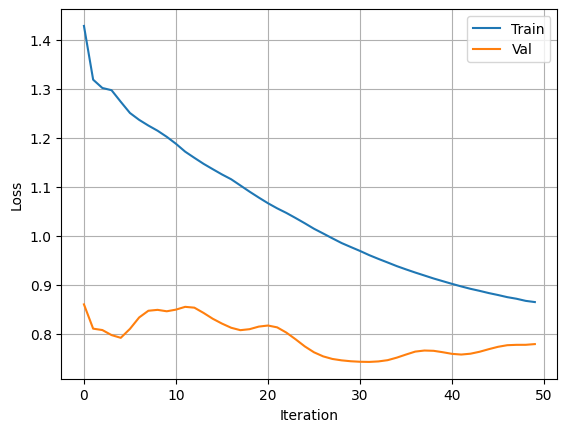

In [50]:
plt.plot(train_loss_history, label="Train")
plt.plot(val_loss_history, label="Val")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()